# Retrieve Data From Last 24 Hours

Grabbing WebIDs ...
WebID collection complete!
16:00:00: Sending API request... Chunk 1 of 1
16:00:00: Response recieved for 1 tags! (0.05)


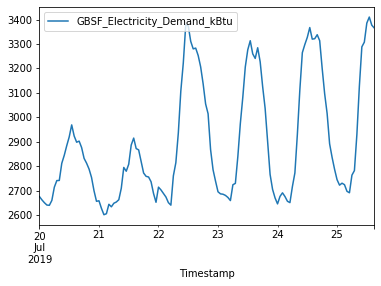

In [55]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle


pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
start = '07-20-2019'
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, end = end, calculation=calculation,
                            interval=interval)
df.plot()


# Add New Variables 

,GBSF_Electricity_Demand_kBtu,rolling_ten,rolling_twenty,rolling_thirty
Timestamp,,,,
2019-07-20 00:00:00,2675.716207,2675.716207,2675.716207,2675.716207
2019-07-20 01:00:00,2662.167877,2668.942042,2668.942042,2668.942042
2019-07-20 02:00:00,2650.559194,2662.814426,2662.814426,2662.814426


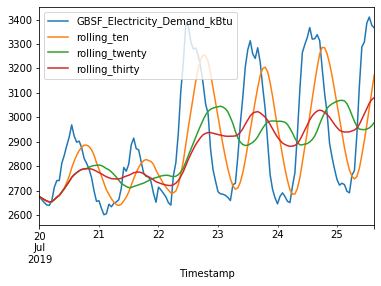

In [56]:
from functools import reduce
rolling_ten = df.rolling(window=10, min_periods=1).mean()
rolling_twenty = df.rolling(window=20, min_periods=1).mean()
rolling_thirty = df.rolling(window=30, min_periods=1).mean()
#merge new variables
df['rolling_ten'] = rolling_ten.values
df['rolling_twenty'] = rolling_twenty.values
df['rolling_thirty'] = rolling_thirty.values

display(df.head(3))
df.plot()

# load the Random Forest Model and fit + predict

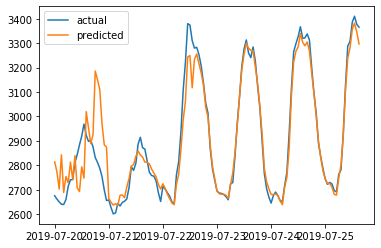

In [57]:
loaded_rf = pickle.load(open('finalized_rf.sav', 'rb'))
#retrieve X_test, y_test from past 24 hours
X_test = df.iloc[:, [1, 2, 3]]
y_preds = np.ravel(loaded_rf.predict(X_test))
y_test = pd.Series(df.iloc[:, 0])
y_preds = pd.Series(y_preds, index = y_test.index)
plt.plot(y_test.index, y_test.values, label = 'actual')
plt.plot(y_preds.index, y_preds.values, label = 'predicted')
plt.legend(loc = 'best')
plt.show()


# Extract Residuals and Retrieve Outliers In Original Data

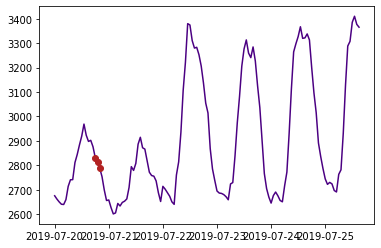

In [62]:
all_df = pd.DataFrame(dict(Actual = y_test.values, Predicted = y_preds.values), index = y_test.index)
all_df.eval('Difference = (Actual - Predicted)/ Actual * 100', inplace=True)
all_df["Difference"] = all_df['Difference'].abs()
resids = all_df['Difference'].tolist()
threshold = np.mean(resids) + 3*np.std(resids)
only_outliers = all_df.loc[all_df.Difference > threshold]
#from only outliers, extract indexes of outliers
outlier_indexes = only_outliers.index.tolist()
plt.plot(all_df.index, all_df.Actual, color = 'indigo')
for index in outlier_indexes:
    date_outlier = index
    actual_outlier = all_df.loc[date_outlier, 'Actual']
    plt.plot(date_outlier, actual_outlier, color = 'firebrick', marker = 'o')

HTML("<b>needs work....:(</b>")